In [2]:
# Importing the required Libraries
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import os
import glob
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train_path = "/kaggle/input/tomatoleafdisease/Tomato Leaf Diseases - Copy/Training Set"
valid_path = "/kaggle/input/tomatoleafdisease/Tomato Leaf Diseases - Copy/Validation Set"
test_path = "/kaggle/input/tomatoleafdisease/Tomato Leaf Diseases - Copy/Testing set"

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True, 
                                   vertical_flip=True)

valid_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [5]:
# Augmenting training data for more training examples
training_set = train_datagen.flow_from_directory("/kaggle/input/tomatoleafdisease/Tomato Leaf Diseases - Copy/Training Set",
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 9500 images belonging to 10 classes.


In [6]:
validation_set = valid_datagen.flow_from_directory("/kaggle/input/tomatoleafdisease/Tomato Leaf Diseases - Copy/Validation Set",
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 7000 images belonging to 10 classes.


In [7]:
resnet_model=tf.keras.applications.resnet50.ResNet50(weights='imagenet', 
                                                         include_top=False, 
                                                         input_shape = (224, 224, 3),
                                                         pooling='max')

94765736/94765736 [==============================] - 0s 0us/step


In [8]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

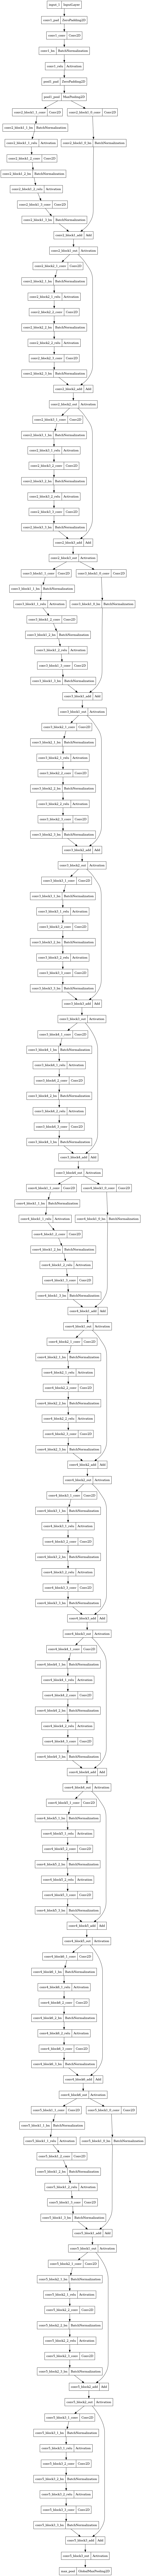

In [10]:
plot_model(resnet_model)

In [12]:
resnetmodel = Sequential()
resnetmodel.add(resnet_model)
#iv3model.add(Flatten())
#iv3model.add(Dense(1024,activation="relu"))
#iv3model.add(Dense(2048,activation="relu"))
resnetmodel.add(Dense(10, activation="softmax"))
resnetmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_1 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________


In [13]:
resnetmodel.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [14]:
model_save = ModelCheckpoint('./resnet.h5', 
                             save_best_only = True, 
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001,  
                           patience = 10, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)
model = resnetmodel.fit(x = training_set, validation_data=validation_set, epochs=20, callbacks = [model_save, early_stop, reduce_lr])

Epoch 1/20
297/297 [==============================] - ETA: 0s - loss: 1.8636 - accuracy: 0.7488
Epoch 1: val_loss improved from inf to 7.38782, saving model to ./resnet.h5
297/297 [==============================] - 248s 662ms/step - loss: 1.8636 - accuracy: 0.7488 - val_loss: 7.3878 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 2/20
297/297 [==============================] - ETA: 0s - loss: 0.5772 - accuracy: 0.8682
Epoch 2: val_loss improved from 7.38782 to 4.95115, saving model to ./resnet.h5
297/297 [==============================] - 161s 541ms/step - loss: 0.5772 - accuracy: 0.8682 - val_loss: 4.9511 - val_accuracy: 0.1559 - lr: 0.0010
Epoch 3/20
297/297 [==============================] - ETA: 0s - loss: 0.6763 - accuracy: 0.8632
Epoch 3: val_loss did not improve from 4.95115
297/297 [==============================] - 159s 535ms/step - loss: 0.6763 - accuracy: 0.8632 - val_loss: 7.1777 - val_accuracy: 0.2191 - lr: 0.0010
Epoch 4/20
297/297 [==============================] - ETA: 0s - l

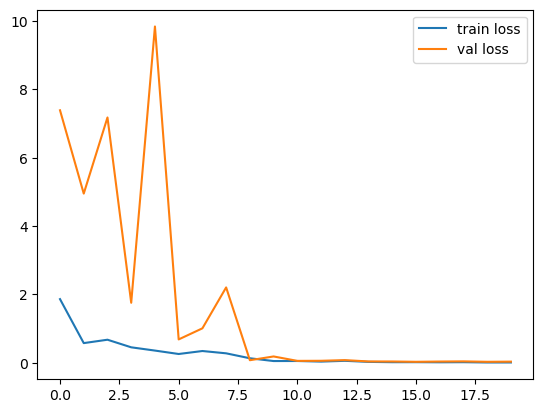

In [15]:
# Loss Plot
plt.plot(model.history['loss'], label='train loss')
plt.plot(model.history['val_loss'], label='val loss')
plt.legend()
plt.show()

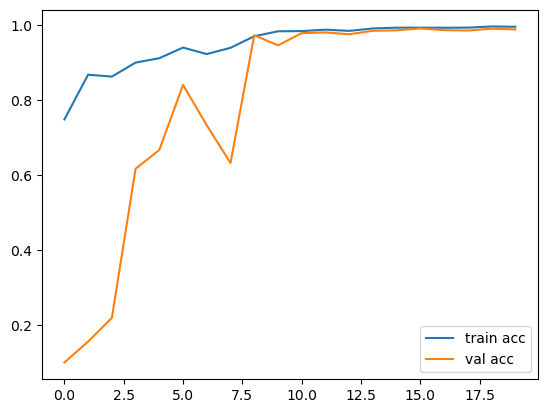

In [16]:
# accuracy plot
plt.plot(model.history['accuracy'], label='train acc')
plt.plot(model.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [17]:
print("training_accuracy", model.history['accuracy'][-1])
print("validation_accuracy", model.history['val_accuracy'][-1])

training_accuracy 0.996210515499115
validation_accuracy 0.9891428351402283


In [18]:
test_set = test_datagen.flow_from_directory("/kaggle/input/tomatoleafdisease/Tomato Leaf Diseases - Copy/Testing set",
                                            target_size = (224, 224),
                                            batch_size = 500,
                                            class_mode = 'categorical')

Found 500 images belonging to 10 classes.


In [19]:
test_data, test_labels = test_set.next()

In [20]:
test_scores = resnetmodel.evaluate(test_data, test_labels)
print("Test Accuracy: ",(test_scores[1]))

16/16 [==============================] - 2s 99ms/step - loss: 0.0411 - accuracy: 0.9900
Test Accuracy:  0.9900000095367432


In [22]:
y_pred_test=resnetmodel.predict(test_data).argmax(axis=1)
print(y_pred_test)

16/16 [==============================] - 1s 58ms/step
[4 1 5 1 0 1 7 2 9 7 5 1 9 7 6 4 9 4 2 7 5 3 4 7 5 6 4 6 7 3 4 9 2 2 9 6 5
 4 7 0 9 4 6 8 6 8 6 4 5 6 1 1 2 8 9 1 6 2 2 6 7 2 0 9 6 8 3 4 3 3 3 1 6 0
 1 0 9 6 7 1 7 9 8 6 7 5 4 2 5 8 8 5 1 8 4 8 9 3 4 2 2 0 4 0 0 9 1 8 2 3 3
 7 1 8 1 3 9 1 6 0 5 8 2 1 4 2 0 1 4 0 6 9 7 9 3 6 6 6 6 3 1 4 2 7 0 6 5 9
 8 1 5 0 9 7 4 0 6 2 7 6 6 5 1 5 1 7 0 3 5 8 0 2 5 6 5 8 5 6 0 6 0 3 0 8 1
 3 6 8 8 6 4 0 3 7 3 9 0 5 8 8 3 7 5 6 9 6 4 7 8 9 8 7 1 7 9 4 6 2 8 0 5 3
 8 4 9 2 9 5 4 5 4 2 0 3 1 8 6 6 1 1 5 9 4 7 5 0 9 0 8 6 2 7 9 9 8 7 2 3 8
 2 8 9 7 8 0 6 0 5 3 9 5 5 8 8 2 7 5 2 7 1 5 6 4 5 9 5 9 7 2 0 4 5 7 4 8 4
 2 1 4 0 0 3 1 2 9 8 9 2 9 9 5 6 1 7 1 2 9 4 9 0 7 0 2 3 4 5 3 5 0 4 4 0 0
 7 5 3 7 1 9 7 3 4 5 1 9 2 1 3 8 6 7 5 3 7 4 1 1 8 0 8 6 8 5 0 6 8 9 6 3 4
 0 3 5 3 9 6 2 5 3 3 1 9 4 7 3 5 4 6 0 5 1 2 0 9 8 4 9 8 0 8 4 3 7 0 5 8 0
 6 1 7 3 1 6 2 3 7 9 4 4 2 1 3 0 6 3 2 3 2 1 8 2 2 9 9 9 1 3 2 8 3 7 8 6 8
 2 1 3 7 9 4 1 0 2 4 3 5 2 2 2 3 4 7 7 4 1 0 7

In [23]:
#Predicting the test data

pred_labels = resnetmodel.predict(test_data)
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels))

16/16 [==============================] - 1s 57ms/step
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        50
           1       1.00      0.98      0.99        50
           2       1.00      1.00      1.00        50
           3       1.00      1.00      1.00        50
           4       1.00      1.00      1.00        50
           5       1.00      0.98      0.99        50
           6       0.96      0.98      0.97        50
           7       1.00      1.00      1.00        50
           8       1.00      1.00      1.00        50
           9       0.96      1.00      0.98        50

   micro avg       0.99      0.99      0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500
 samples avg       0.99      0.99      0.99       500



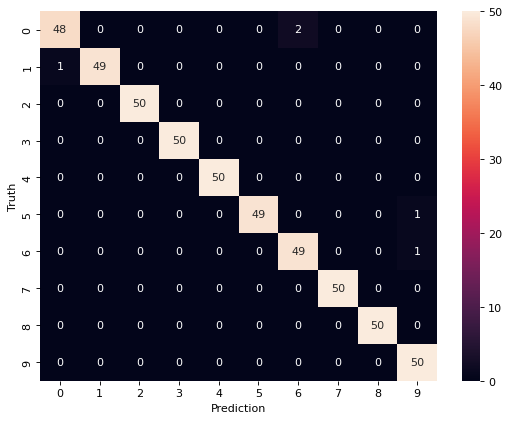

In [24]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [25]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
# model = load_model("my_best_model.hdf5")
img = image.load_img('/kaggle/input/tomatoleafdisease/Tomato Leaf Diseases - Copy/Testing set/Tomato___Late_blight/image (902).JPG', target_size=(224,224))
x = image.img_to_array(img)/255
x = np.expand_dims(x, axis=0)
classes = resnetmodel.predict(x)
print (classes)
# predicting images
#image = image.convert("RGB")
result = np.argmax(classes)
dic=dict(training_set.class_indices)
print([key for key in dic.keys()][result]) 

1/1 [==============================] - 0s 344ms/step
[[7.7658349e-12 3.1794250e-04 9.9968183e-01 2.9133901e-07 3.7052070e-10
  3.6802736e-10 2.4782634e-09 1.6354220e-09 3.7097243e-22 4.1650658e-10]]
Tomato___Late_blight
